<a href="https://colab.research.google.com/github/evpozdniakov/ds_projects/blob/master/hw12/reduction_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
country_data = pd.read_csv('https://github.com/evpozdniakov/ds_projects/raw/master/hw12/data/Country-data.csv')
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [36]:
country = country_data.copy()

Каково максимальное значение показателя средней продолжительности жизни среди представленных стран? Ответ округлите до одного знака после точки-разделителя.

In [14]:
country[['country', 'life_expec']].sort_values('life_expec', ascending=False)

,country,life_expec
77,Japan,82.8
133,Singapore,82.7
145,Switzerland,82.2
68,Iceland,82.0
7,Australia,82.0
...,...,...
94,Malawi,53.1
166,Zambia,52.0
31,Central African Republic,47.5
87,Lesotho,46.5


Чтобы получить более качественные результаты, необходимо стандартизировать данные. Используйте для этого StandardScaler. Примените его ко всем значениям признаков и впишите в качестве ответа значение первого признака для первого объекта (таким образом можно будет проверить, что вы всё сделали корректно). Ответ округлите до двух знаков после точки-разделителя.

In [40]:
from sklearn import preprocessing as ce

country2 = country.copy()
columns_to_scale = country2.select_dtypes(include='number').columns.values
# create scaler once and fit it to some initial data
scaler = ce.StandardScaler()

scaler.fit(country2[columns_to_scale])
# use the scaler for data (once or many times)
ndarr = scaler.transform(country2[columns_to_scale])
# create a DataFrame out of ndarr
norm_df = pd.DataFrame(ndarr, columns=columns_to_scale).set_index(country2.index)
# update the transformed columns data
country2.loc[:, columns_to_scale] = norm_df[columns_to_scale]

print(round(country2[columns_to_scale].iloc[0][0], 2))

1.29


Как вы помните, нет смысла использовать сильно связанные друг с другом признаки, так как их можно преобразовать в один и таким образом уменьшить общее количество признаков. Давайте выясним, есть ли в данных такие признаки.

Постройте матрицу корреляций для всех признаков. Найдите максимальный коэффициент корреляции. Запишите его в качестве ответа, предварительно округлив до двух знаков после точки-разделителя.

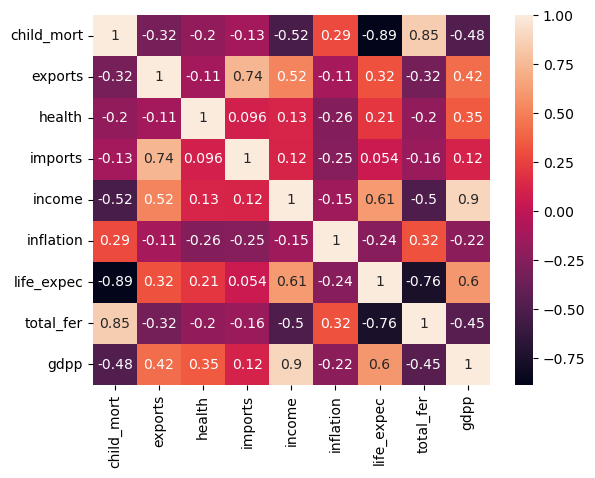

In [43]:
import seaborn as sns

sns.heatmap(country2.corr(), annot=True);

Теперь понизим размерность данных — возьмём для этого метод главных компонент (PCA) как самый простой и популярный.

Найдите минимальное число компонент, которые суммарно могут объяснить как минимум 90 % разброса данных.

In [47]:
from sklearn.decomposition import PCA

pca = PCA(
    n_components=0.9, # сколько признаков хотим получить (int) или какую долю дисперсии хотим сохранить (float)
    random_state=42)

X_pca = pca.fit_transform(country2.select_dtypes(include='number'))

X_pca.shape

(167, 5)

Используйте главные компоненты, выделенные в предыдущем задании.

Какую долю дисперсии объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.

In [50]:
round(pca.explained_variance_ratio_[0], 2)

0.46

Как вы помните, при создании компонент с помощью PCA они должны получиться независимыми, то есть мы не должны теперь наблюдать высоких коэффициентов корреляции.

Постройте матрицу корреляций. Сколько значений в ней превышают , не считая единичных значений на главной диагонали?

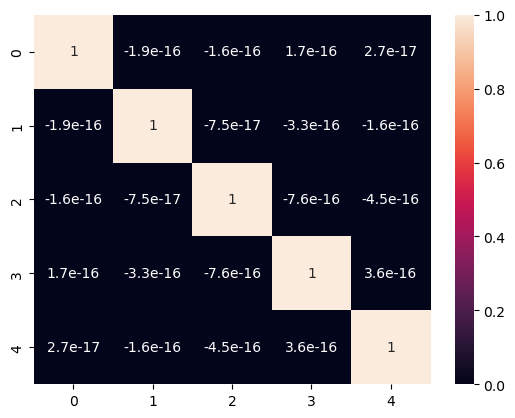

In [63]:
country3 = pd.DataFrame(data=X_pca)
country3['country'] = country2['country']

sns.heatmap(country3.corr(), annot=True);

Как видим, даже самый большой коэффициент корреляции практически неотличим от нуля — это значит, что мы всё сделали правильно, и теперь у нас есть пять независимых признаков, объясняющих до 90 % дисперсии.

Теперь, когда мы уменьшили размерность данных, можно переходить к кластеризации. Подберите оптимальное количество кластеров с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. Для кластеризации используйте алгоритм k-means++. В качестве значения параметра random_state возьмите число 1.

Судя по полученным результатам, сколько кластеров лучше всего взять?

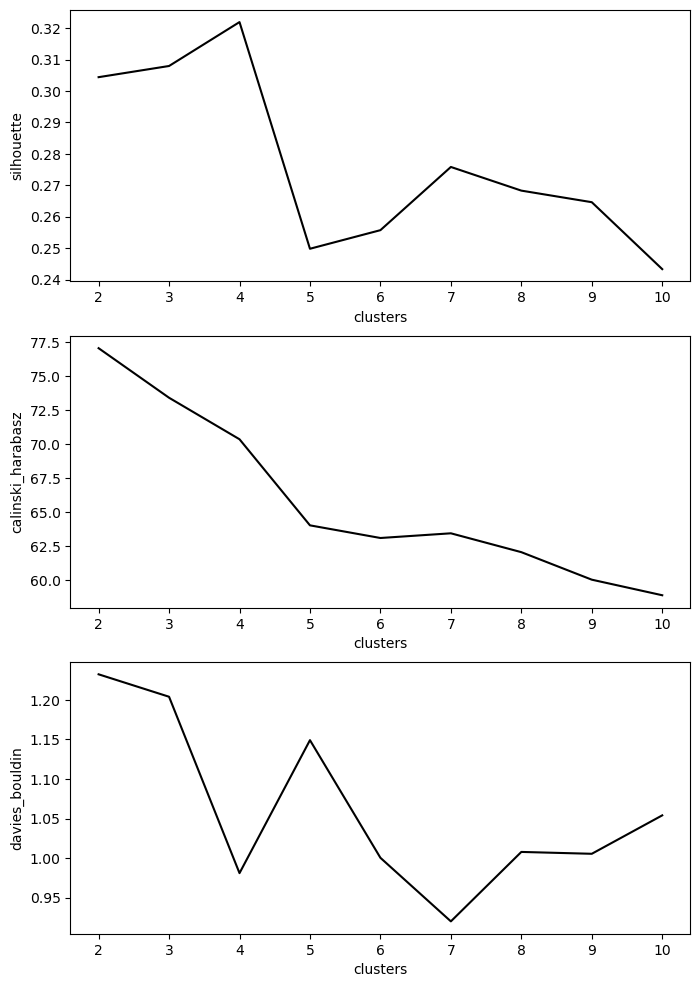

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans

def figax(name, figsize=(7, 4), rowcol=None, axes=[0,0,1,1]):
    fig = plt.figure(name, figsize=figsize)

    if rowcol is None:
        ax = fig.add_axes(axes)
    else:
        rows, cols = rowcol
        ax = fig.subplots(rows, cols)

    return fig, ax

def draw_cluster_metrics(X, k_range=range(2, 10)):
    def get_metric_scores(X, k):
        km = KMeans(n_clusters=k, random_state=1)
        km.fit_predict(X)
        return (
            k,
            metrics.silhouette_score(X, km.labels_),
            metrics.calinski_harabasz_score(X, km.labels_),
            metrics.davies_bouldin_score(X, km.labels_),
        )

    metric_scores_data = pd.DataFrame(
        data=[get_metric_scores(X, k) for k in k_range],
        columns=['clusters', 'silhouette', 'calinski_harabasz', 'davies_bouldin'],
    )

    fig, ax = figax('cluster_metrics', figsize=(8, 12), rowcol=(3, 1))
    sns.lineplot(ax=ax[0], data=metric_scores_data, x='clusters', y='silhouette', color='black')
    sns.lineplot(ax=ax[1], data=metric_scores_data, x='clusters', y='calinski_harabasz', color='black')
    sns.lineplot(ax=ax[2], data=metric_scores_data, x='clusters', y='davies_bouldin', color='black')

    return metric_scores_data

metric_scores_data = draw_cluster_metrics(X_pca, k_range=range(2, 11))

Теперь, когда оптимальное количество кластеров выбрано, реализуйте алгоритм k-means++ с этим параметром. В качестве значения random_state возьмите число 1.

В какой кластер попали страны, у которых самый высокий показатель детской смертности и самый низкий ВВП на душу населения?

In [66]:
k_means = KMeans(
    n_clusters=4,
    random_state=1,
)

k_means.fit(X_pca);

country3.loc[:, 'label'] = k_means.labels_

In [86]:
high_child_mort_countries = country.sort_values('child_mort', ascending=False)['country'][:10].values
low_gdpp_countries = country.sort_values('gdpp', ascending=True)['country'][:10].values
both_issues_countries = set(high_child_mort_countries) & set(low_gdpp_countries)

m = country3['country'].isin(both_issues_countries)
country3[m][['country', 'label']]

,country,label
31,Central African Republic,1
37,"Congo, Dem. Rep.",1
112,Niger,1
132,Sierra Leone,1


Итак, мы понимаем, что именно в выбранном нами кластере находятся страны, которые особенно остро нуждаются в финансовой помощи. Однако на все страны у нас не хватит ресурсов, поэтому давайте выберем из выделенного кластера три страны, в которых самая маленькая продолжительность жизни.

In [87]:
m = country3['label'] == 1
label_1_countries = country3[m]['country']

m = country['country'].isin(label_1_countries)
country[m].sort_values('life_expec', ascending=True)[['country', 'life_expec']][:3]

,country,life_expec
66,Haiti,32.1
87,Lesotho,46.5
31,Central African Republic,47.5
